In [ ]:
import pandas as pd
import numpy as np

import os
import sys
import cv2

import seaborn as sns
import torch
import requests
import pickle

from google.colab.patches import cv2_imshow

from PIL import Image
from io import BytesIO

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML,display, Javascript,HTML, Audio, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import base64
from base64 import b64decode
from moviepy.editor import VideoFileClip

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential,load_model
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.utils.np_utils import to_categorical

import tensorflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop



In [ ]:
def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");

      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});

      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();

      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
video_path = "test.mp4"
record_video(video_path)

<IPython.core.display.Javascript object>

Finished recording video at:test.mp4


In [ ]:
show_video(video_path)

In [ ]:
import cv2

# Get the video path
video_path = "/content/test.mp4"

# Create a VideoCapture object
cap = cv2.VideoCapture(video_path)

# Get the number of frames in the video
#num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
num_frames = 30

# Create a list to store the frames
frames = []

# Iterate over the frames in the video
for i in range(num_frames):
    # Read the next frame
    ret, frame = cap.read()

    # If the frame was read successfully, add it to the list
    if ret:
        frames.append(frame)

# Save the frames to a directory
output_dir = "/content/test_images"

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Iterate over the frames in the list
for i, frame in enumerate(frames):
    # Save the frame to a file
    cv2.imwrite(os.path.join(output_dir, "frame%d.jpg" % i), frame)

# Close the VideoCapture object
cap.release()


# Compare Video

In [ ]:
image_src = '/content/WIN_20230620_10_57_28_Pro.jpg

SyntaxError: ignored

<h1>Version 1</h1>

In [ ]:
!gdown 1iZDDRrvmy_w9KflV8CNQ_axabYF5-7m5
!gdown 1gFSRU4v1WLBny53r2wIt3B-gy9lrjdlb

Downloading...
From: https://drive.google.com/uc?id=1iZDDRrvmy_w9KflV8CNQ_axabYF5-7m5
To: /content/model\emotion_detection_from_image_final.h5
100% 47.5M/47.5M [00:02<00:00, 17.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gFSRU4v1WLBny53r2wIt3B-gy9lrjdlb
To: /content/haarcascade_frontalface_default.xml
100% 1.29M/1.29M [00:00<00:00, 168MB/s]


In [ ]:
path = '/content/model\emotion_detection_from_image_final.h5'

model = load_model(path)

In [ ]:
model.history

In [ ]:
path = '/content/model\emotion_detection_from_image_final.h5'

model = load_model(path)

classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

int2emotions = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'neutral',5:'sad',6:'surprise'}

def detect_face(input):
    image = cv2.imread(input)
    frame = np.array(image)

    text_out = "Error"
    arr=[]

    faces = classifier.detectMultiScale(image,1.3,4)
    if faces==():
        return frame,text_out,arr
    for x,y,w,h in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(172,42,251),2)
        face = frame[y:y+h,x:x+w]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face,(48,48))
        face = face.reshape(1,48,48,1)
        cv2.putText(frame,text=int2emotions[np.argmax(model.predict(face))], org=(x,y-15),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(106,40,243),thickness=2)
        text_out = int2emotions[np.argmax(model.predict(face))]
        arr = model.predict(face)
    return frame, text_out, arr

  if faces==():



1/1 [==============================] - 0s 19ms/step


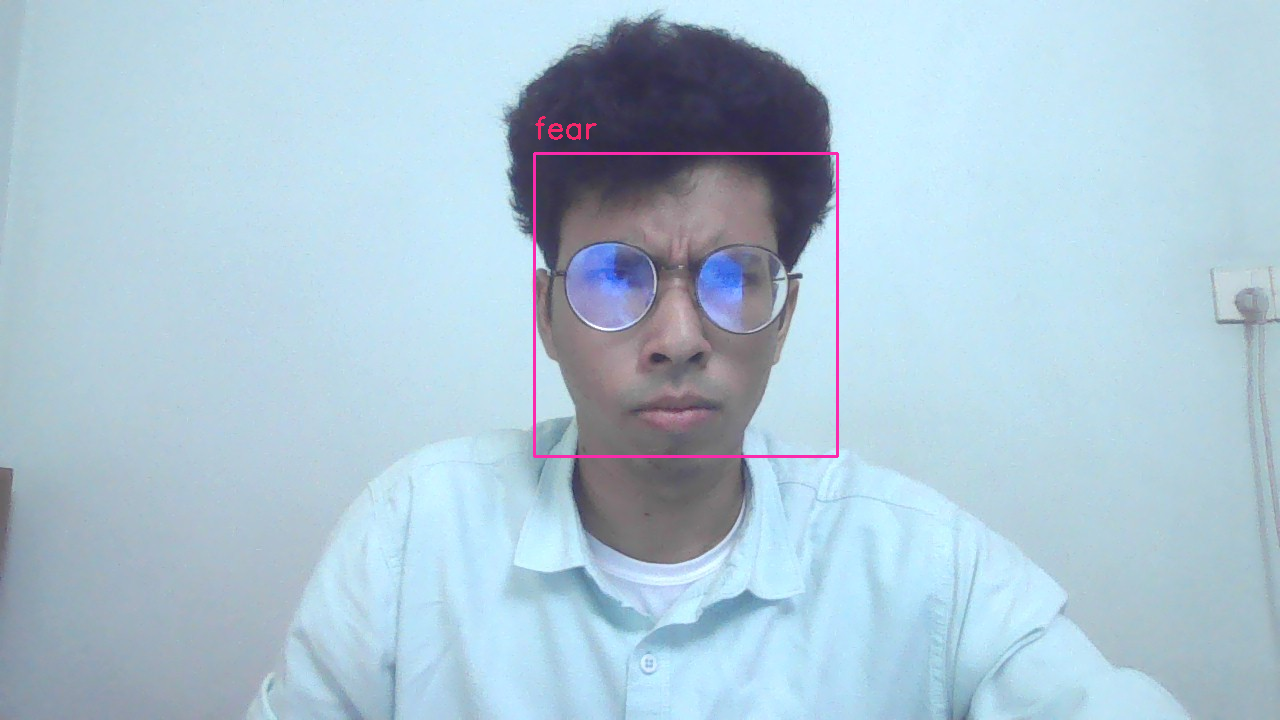

fear
[[0.26597932 0.09415848 0.40176347 0.0089866  0.03386453 0.09989057
  0.09535712]]


In [ ]:
out1,text,arr = detect_face(image_src)
cv2_imshow(out1)
print(text)
print(arr)

cv2.destroyAllWindows()

<h2>Version 2</h2>

In [ ]:
!pip install fer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=98ce21ac41191a6536dfd8b97cc6f3d1e0d2c09b946dbeebbc47a3479a651d13
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
from fer import FER
import cv2

img = cv2.imread(image_src)
detector = FER(mtcnn=True)
detector.detect_emotions(img)

[{'box': [96, 82, 132, 174],
  'emotions': {'angry': 0.16,
   'disgust': 0.0,
   'fear': 0.0,
   'happy': 0.0,
   'sad': 0.02,
   'surprise': 0.0,
   'neutral': 0.82}}]

<h1>Version 3</h1>
From Video

In [ ]:
!pip install fer
import fer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
from fer import Video
from fer import FER
import matplotlib.pyplot as plt
import os
import sys
# fn contains the video file name (Ensure that you only upload one file)
videofile = '/content/test.mp4'
# Face detection
detector = FER(mtcnn=True)
# Video predictions
video = Video(videofile)

# Output list of dictionaries
raw_data = video.analyze(detector, display=False)

AssertionError: ignored

In [ ]:
df = video.to_pandas(raw_data)
df = video.get_first_face(df)
df = video.get_emotions(df)

In [ ]:
df

,angry,disgust,fear,happy,sad,surprise,neutral
0,0.02,0.0,0.02,0.0,0.06,0.0,0.89
1,0.03,0.0,0.03,0.0,0.07,0.0,0.87
2,0.02,0.0,0.01,0.0,0.05,0.0,0.91
3,0.02,0.0,0.01,0.0,0.04,0.0,0.93
4,0.01,0.0,0.01,0.0,0.03,0.0,0.94
...,...,...,...,...,...,...,...
474,0.03,0.0,0.02,0.0,0.04,0.0,0.91
475,0.03,0.0,0.02,0.0,0.03,0.0,0.92
476,0.03,0.0,0.02,0.0,0.02,0.0,0.93
477,0.03,0.0,0.01,0.0,0.03,0.0,0.92


In [ ]:
emo_sum = df.sum(axis=0)
print(emo_sum)
print(max(emo_sum))


angry         9.65
disgust       0.00
fear          6.02
happy         0.00
sad          14.45
surprise      0.00
neutral     448.36
dtype: float64
448.35999999999996


<h1>Version 4</h1>

In [ ]:
!pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=b6a5ce09c3acee31f5006d2de6099f8c56b0ba3e80d87c63657bb1de078d24c3
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
from deepface import DeepFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
face_analysis = DeepFace.analyze(img_path = image_src)

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 19.9MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:07<00:00, 70.3MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:08<00:00, 67.0MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:08<00:00, 66.4MB/s]
Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


In [ ]:
face_analysis

[{'emotion': {'angry': 2.6741824754594745e-06,
   'disgust': 3.307232349851301e-12,
   'fear': 1.0897953063249588,
   'happy': 3.4521960401434626e-05,
   'sad': 1.1507170771807296e-07,
   'surprise': 98.91015887260437,
   'neutral': 1.1697861879156335e-05},
  'dominant_emotion': 'surprise',
  'region': {'x': 51, 'y': 44, 'w': 97, 'h': 97},
  'age': 32,
  'gender': {'Woman': 99.2051362991333, 'Man': 0.7948605343699455},
  'dominant_gender': 'Woman',
  'race': {'asian': 1.629132591187954,
   'indian': 1.0786522179841995,
   'black': 0.08991272188723087,
   'white': 63.32409977912903,
   'middle eastern': 16.3902685046196,
   'latino hispanic': 17.487934231758118},
  'dominant_race': 'white'}]